<a href="https://colab.research.google.com/github/tanuja1708/EEG-emotions/blob/main/other%20models%20existed.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import zipfile
import os

zip_path = '/content/drive/MyDrive/cbam_bandwise_labels.zip'
extract_path = '/content/cbam_bandwise_labels'  # We'll extract here

# Unzip
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

print("✅ Unzipped cbam_bandwise_labels to:", extract_path)


✅ Unzipped cbam_bandwise_labels to: /content/cbam_bandwise_labels


In [3]:
import numpy as np

gan_path = '/content/drive/MyDrive/gan_augmented_data_10000.npz'
gan_data = np.load(gan_path)

gan_features = gan_data['features']  # Shape: (10000, 5, 8, 9)
gan_labels = gan_data['labels']      # Shape: (10000, 4) or (10000,)

print("GAN features shape:", gan_features.shape)
print("GAN labels shape:", gan_labels.shape)


GAN features shape: (10000, 5, 8, 9)
GAN labels shape: (10000, 4)


In [5]:
# --- 0. Setup & Mount Drive ---
from google.colab import drive
drive.mount('/content/drive')

import os, zipfile
import numpy as np
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import OneHotEncoder
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

# --- 1. Extract Real EEG Data ---
zip_path = '/content/drive/MyDrive/cbam_bandwise_labels.zip'
extract_path = '/content/cbam_bandwise_labels'
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# --- 2. Load Real EEG Data ---
real_features, real_labels = [], []
for fname in os.listdir(extract_path):
    if fname.endswith('.npz'):
        data = np.load(os.path.join(extract_path, fname))
        real_features.append(data['features'])  # (N, 5, 8, 9)
        real_labels.append(data['labels'])

real_features = np.concatenate(real_features)
real_labels = np.concatenate(real_labels).reshape(-1, 1)

encoder = OneHotEncoder(sparse_output=False)
real_labels_onehot = encoder.fit_transform(real_labels)

# --- 3. Load GAN Data ---
gan = np.load('/content/drive/MyDrive/gan_augmented_data_10000.npz')
gan_features = gan['features']
gan_logits = gan['labels']
gan_class_indices = np.argmax(gan_logits, axis=1).reshape(-1, 1) if gan_logits.ndim > 1 else gan_logits.reshape(-1, 1)
gan_labels_onehot = encoder.transform(gan_class_indices)

# --- 4. Combine Real + GAN ---
features = np.concatenate([real_features, gan_features])
labels = np.concatenate([real_labels_onehot, gan_labels_onehot])
labels = np.argmax(labels, axis=1)
print("✅ Combined dataset shape:", features.shape)
print("🧾 Label distribution:", Counter(labels))

# --- 5. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# --- 6. Custom Dataset ---
class EEGDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
    def __len__(self): return len(self.X)
    def __getitem__(self, idx):
        return torch.tensor(self.X[idx], dtype=torch.float32), torch.tensor(self.y[idx], dtype=torch.long)

train_loader = DataLoader(EEGDataset(X_train, y_train), batch_size=64, shuffle=True)
test_loader = DataLoader(EEGDataset(X_test, y_test), batch_size=64, shuffle=False)

# --- 7. CBAM Module ---
class CBAM(nn.Module):
    def __init__(self, ch, reduction=16):
        super().__init__()
        self.avg = nn.AdaptiveAvgPool2d(1)
        self.max = nn.AdaptiveMaxPool2d(1)
        self.mlp = nn.Sequential(
            nn.Conv2d(ch, ch // reduction, 1, bias=False), nn.ReLU(),
            nn.Conv2d(ch // reduction, ch, 1, bias=False)
        )
        self.sigmoid = nn.Sigmoid()
        self.spatial = nn.Sequential(
            nn.Conv2d(2, 1, kernel_size=7, padding=3, bias=False), nn.Sigmoid()
        )
    def forward(self, x):
        avg = self.mlp(self.avg(x))
        maxx = self.mlp(self.max(x))
        x = x * self.sigmoid(avg + maxx)
        avg_out = torch.mean(x, 1, keepdim=True)
        max_out, _ = torch.max(x, 1, keepdim=True)
        x = x * self.spatial(torch.cat([avg_out, max_out], dim=1))
        return x

# --- 8. CBAM-ResNet + BiLSTM Model ---
class CBAM_ResNet_BiLSTM(nn.Module):
    def __init__(self, num_classes=4):
        super().__init__()
        self.conv1 = nn.Conv2d(5, 32, kernel_size=3, padding=1)
        self.cbam1 = CBAM(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.cbam2 = CBAM(64)
        self.resblock = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(64, 64, kernel_size=3, padding=1)
        )
        self.relu = nn.ReLU()
        self.bilstm = nn.LSTM(input_size=64*9, hidden_size=128, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(128*2, num_classes)

    def forward(self, x):
        x = self.relu(self.cbam1(self.conv1(x)))
        x = self.relu(self.cbam2(self.conv2(x)))
        res = x
        x = self.resblock(x)
        x += res
        x = self.relu(x)
        x = x.view(x.size(0), x.size(2), -1)  # (B, time=8, 64*9)
        x, _ = self.bilstm(x)
        x = self.fc(x[:, -1, :])  # last timestep
        return x

# --- 9. Training ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CBAM_ResNet_BiLSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.0005)
criterion = nn.CrossEntropyLoss()

for epoch in range(1, 210):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for X, y in train_loader:
        X, y = X.to(device), y.to(device)
        optimizer.zero_grad()
        out = model(X)
        loss = criterion(out, y)
        loss.backward()
        optimizer.step()
        loss_sum += loss.item()
        _, pred = out.max(1)
        correct += (pred == y).sum().item()
        total += y.size(0)
    acc = 100 * correct / total
    print(f"Epoch {epoch:03d} | Loss: {loss_sum:.3f} | Train Acc: {acc:.2f}%")

# --- 10. Evaluation ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)
        out = model(X)
        _, pred = torch.max(out, 1)
        y_true += y.cpu().numpy().tolist()
        y_pred += pred.cpu().numpy().tolist()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Sad', 'Fear', 'Happy']))
print(f"✅ Final Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# --- 11. Save ---
torch.save(model.state_dict(), '/content/cbam_resnet_bilstm.pth')
print("💾 Model saved to /content/cbam_resnet_bilstm.pth")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
✅ Combined dataset shape: (11080, 5, 8, 9)
🧾 Label distribution: Counter({np.int64(2): 5953, np.int64(1): 2794, np.int64(0): 2043, np.int64(3): 290})
Epoch 001 | Loss: 154.646 | Train Acc: 53.33%
Epoch 002 | Loss: 152.462 | Train Acc: 53.33%
Epoch 003 | Loss: 152.150 | Train Acc: 53.33%
Epoch 004 | Loss: 152.302 | Train Acc: 53.33%
Epoch 005 | Loss: 152.336 | Train Acc: 53.33%
Epoch 006 | Loss: 152.154 | Train Acc: 53.33%
Epoch 007 | Loss: 152.193 | Train Acc: 53.33%
Epoch 008 | Loss: 152.219 | Train Acc: 53.33%
Epoch 009 | Loss: 152.066 | Train Acc: 53.33%
Epoch 010 | Loss: 152.057 | Train Acc: 53.33%
Epoch 011 | Loss: 152.087 | Train Acc: 53.33%
Epoch 012 | Loss: 152.086 | Train Acc: 53.33%
Epoch 013 | Loss: 152.037 | Train Acc: 53.33%
Epoch 014 | Loss: 151.943 | Train Acc: 53.33%
Epoch 015 | Loss: 151.925 | Train Acc: 53.33%
Epoch 016 | Loss: 151.432 | Tra

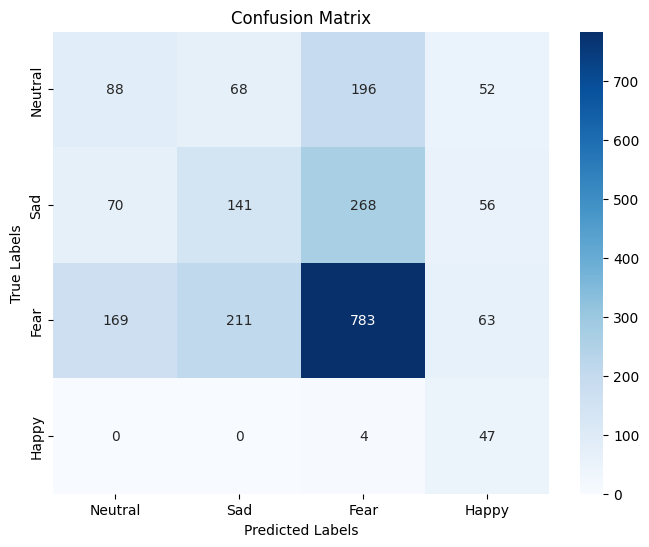

In [7]:
# --- 10. Confusion Matrix ---
from sklearn.metrics import confusion_matrix # Import the confusion_matrix function
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Sad', 'Fear', 'Happy'], yticklabels=['Neutral', 'Sad', 'Fear', 'Happy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

GAN logits shape: (10000, 4)
Combined features shape: (11080, 5, 8, 9)
Combined labels shape: (11080, 4)
Label distribution after combining: Counter({np.int64(2): 5953, np.int64(1): 2794, np.int64(0): 2043, np.int64(3): 290})


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200 | Loss: 193.550 | Train Acc: 32.57%
Epoch 2/200 | Loss: 192.915 | Train Acc: 33.61%
Epoch 3/200 | Loss: 192.646 | Train Acc: 36.56%
Epoch 4/200 | Loss: 192.757 | Train Acc: 33.11%
Epoch 5/200 | Loss: 192.604 | Train Acc: 36.18%
Epoch 6/200 | Loss: 192.645 | Train Acc: 37.74%
Epoch 7/200 | Loss: 192.682 | Train Acc: 35.56%
Epoch 8/200 | Loss: 192.639 | Train Acc: 49.32%
Epoch 9/200 | Loss: 192.600 | Train Acc: 40.47%
Epoch 10/200 | Loss: 192.500 | Train Acc: 36.62%
Epoch 11/200 | Loss: 192.589 | Train Acc: 35.65%
Epoch 12/200 | Loss: 192.545 | Train Acc: 39.08%
Epoch 13/200 | Loss: 192.573 | Train Acc: 44.86%
Epoch 14/200 | Loss: 192.558 | Train Acc: 49.20%
Epoch 15/200 | Loss: 192.569 | Train Acc: 50.61%
Epoch 16/200 | Loss: 192.569 | Train Acc: 49.99%
Epoch 17/200 | Loss: 192.539 | Train Acc: 49.42%
Epoch 18/200 | Loss: 192.516 | Train Acc: 30.67%
Epoch 19/200 | Loss: 192.527 | Train Acc: 44.28%
Epoch 20/200 | Loss: 192.512 | Train Acc: 42.61%
Epoch 21/200 | Loss: 192.583 

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


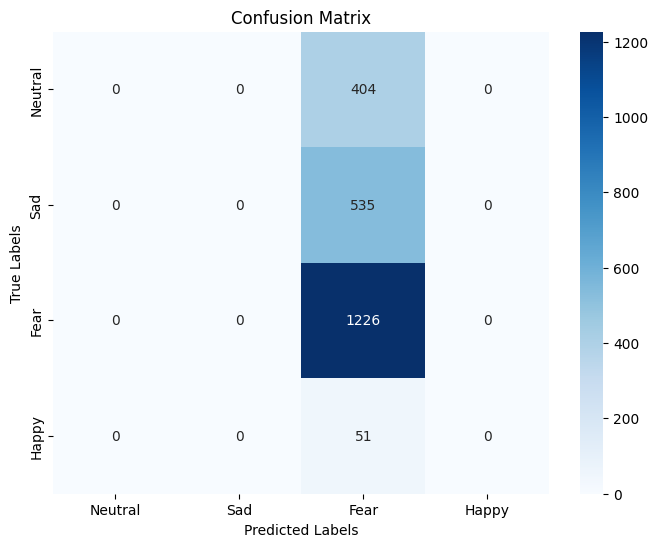

💾 Model saved to /content/cnn_transformer_bilstm_weighted_loss.pth


In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Real + GAN Data ---
# Load real dataset from .npz files
real_data_folder = '/content/cbam_bandwise_labels'
real_features = []
real_labels = []

for file_name in os.listdir(real_data_folder):
    if file_name.endswith('.npz'):
        data = np.load(os.path.join(real_data_folder, file_name))
        features = data['features']
        labels = data['labels']

        real_features.append(features)
        real_labels.append(labels)

real_features = np.concatenate(real_features, axis=0)  # (11080, 5, 8, 9)
real_labels = np.concatenate(real_labels, axis=0).reshape(-1, 1)  # (11080, 1)

# One-hot encode real labels
encoder = OneHotEncoder(sparse_output=False)
real_labels_one_hot = encoder.fit_transform(real_labels)

# Load GAN-generated data
gan_data = np.load('/content/drive/MyDrive/gan_augmented_data_10000.npz')
gan_features = gan_data['features']  # (10000, 5, 8, 9)
gan_logits = gan_data['labels']      # (10000, 4)
print("GAN logits shape:", gan_logits.shape)
# Convert GAN logits to class indices
if gan_logits.ndim == 1:
    gan_class_indices = gan_logits.reshape(-1, 1)
else:
    gan_class_indices = np.argmax(gan_logits, axis=1).reshape(-1, 1)

# Convert to one-hot encoding using the same encoder
gan_labels_one_hot = encoder.transform(gan_class_indices)

# --- 2. Combine Real and GAN Data ---
combined_features = np.concatenate((real_features, gan_features), axis=0)
combined_labels = np.concatenate((real_labels_one_hot, gan_labels_one_hot), axis=0)

print(f"Combined features shape: {combined_features.shape}")
print(f"Combined labels shape: {combined_labels.shape}")

# Convert one-hot labels back to class indices
combined_labels = np.argmax(combined_labels, axis=1)

# Print label distribution
print("Label distribution after combining:", Counter(combined_labels))

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, test_size=0.2, random_state=42
)

# --- 4. Custom Dataset ---
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 5. Define the Model (CNN + Transformer + BiLSTM) ---
class CNN_Transformer_BiLSTM(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_Transformer_BiLSTM, self).__init__()

        # CNN layers for feature extraction
        self.conv1 = nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)

        # Transformer encoder for attention mechanism
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(
            d_model=64, nhead=4, dim_feedforward=256
        )
        self.transformer_encoder = nn.TransformerEncoder(
            self.transformer_encoder_layer, num_layers=4
        )

        # BiLSTM layer
        self.bilstm = nn.LSTM(64, 128, batch_first=True, bidirectional=True)

        # Fully connected layer
        self.fc = nn.Linear(128 * 2, num_classes)

    def forward(self, x):
        # CNN feature extraction
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)

        # Reshaping to (batch_size, seq_length, feature_dim) for transformer input
        # Calculate the size of the output after CNN layers
        batch_size, channels, height, width = x.size()  # Should be (batch_size, 64, height, width)

        # Flatten the spatial dimensions (height, width) and keep the channel dimension
        x = x.view(batch_size, channels, -1).permute(0, 2, 1)  # Shape becomes (batch_size, seq_len, feature_dim)

        # Transformer attention mechanism
        x = self.transformer_encoder(x)

        # BiLSTM for temporal dependencies
        x, _ = self.bilstm(x)

        # Use the output of the last time step
        x = self.fc(x[:, -1, :])

        return x


# --- 6. Calculate Class Weights ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# --- 7. Loss Function with Class Weights ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- 8. Train the Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_Transformer_BiLSTM().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_sum:.3f} | Train Acc: {train_accuracy:.2f}%")

# --- 9. Evaluate the Model ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Sad', 'Fear', 'Happy']))
print(f"✅ Final Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# --- 10. Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Sad', 'Fear', 'Happy'], yticklabels=['Neutral', 'Sad', 'Fear', 'Happy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- 11. Save the Model ---
torch.save(model.state_dict(), '/content/cnn_transformer_bilstm_weighted_loss.pth')
print("💾 Model saved to /content/cnn_transformer_bilstm_weighted_loss.pth")


In [12]:
from collections import Counter

# Counting the occurrences of each emotion class in the combined dataset
emotion_counts = Counter(combined_labels)

# Print the number of samples for each emotion
print("Emotion class distribution in the combined dataset:")
for label, count in emotion_counts.items():
    emotion_name = encoder.categories_[0][label]  # Convert label index to emotion name
    print(f"{emotion_name}: {count} samples")


Emotion class distribution in the combined dataset:
1: 2794 samples
2: 5953 samples
3: 290 samples
0: 2043 samples


GAN logits shape: (10000, 4)
Combined features shape: (11080, 5, 8, 9)
Combined labels shape: (11080, 4)
Label distribution after combining: Counter({np.int64(2): 5953, np.int64(1): 2794, np.int64(0): 2043, np.int64(3): 290})


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Epoch 1/200 | Loss: 113.338 | Train Acc: 25.09%
Epoch 2/200 | Loss: 112.434 | Train Acc: 24.62%
Epoch 3/200 | Loss: 111.415 | Train Acc: 24.67%
Epoch 4/200 | Loss: 107.357 | Train Acc: 26.85%
Epoch 5/200 | Loss: 111.461 | Train Acc: 24.91%
Epoch 6/200 | Loss: 112.131 | Train Acc: 24.58%
Epoch 7/200 | Loss: 83.308 | Train Acc: 35.00%
Epoch 8/200 | Loss: 68.092 | Train Acc: 44.13%
Epoch 9/200 | Loss: 94.928 | Train Acc: 33.88%
Epoch 10/200 | Loss: 112.029 | Train Acc: 24.62%
Epoch 11/200 | Loss: 109.667 | Train Acc: 25.43%
Epoch 12/200 | Loss: 109.361 | Train Acc: 25.38%
Epoch 13/200 | Loss: 109.273 | Train Acc: 25.39%
Epoch 14/200 | Loss: 110.971 | Train Acc: 25.07%
Epoch 15/200 | Loss: 113.281 | Train Acc: 24.47%
Epoch 16/200 | Loss: 108.693 | Train Acc: 25.69%
Epoch 17/200 | Loss: 109.641 | Train Acc: 25.42%
Epoch 18/200 | Loss: 109.229 | Train Acc: 25.51%
Epoch 19/200 | Loss: 110.552 | Train Acc: 25.21%
Epoch 20/200 | Loss: 111.761 | Train Acc: 24.54%
Epoch 21/200 | Loss: 111.553 | T

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Neutral       0.00      0.00      0.00       404
         Sad       0.00      0.00      0.00       535
        Fear       0.00      0.00      0.00      1226
       Happy       0.02      1.00      0.04        51

    accuracy                           0.02      2216
   macro avg       0.01      0.25      0.01      2216
weighted avg       0.00      0.02      0.00      2216

✅ Final Test Accuracy: 2.30%


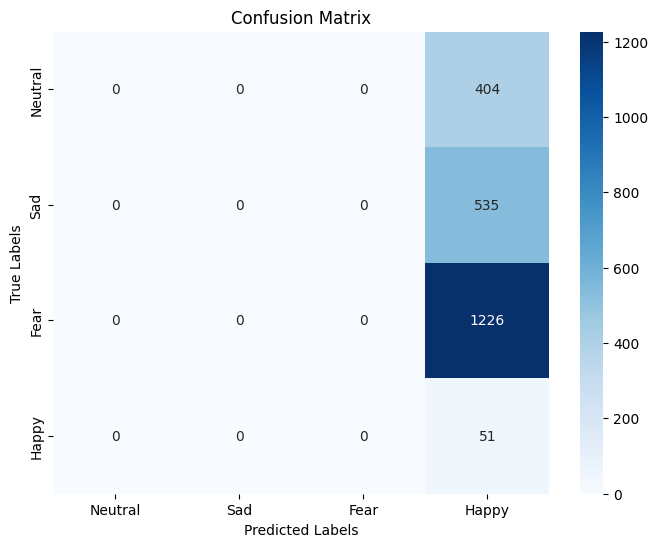

💾 Model saved to /content/cnn_transformer_weighted_loss.pth


In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Real + GAN Data ---
# Load real dataset from .npz files
real_data_folder = '/content/cbam_bandwise_labels'
real_features = []
real_labels = []

for file_name in os.listdir(real_data_folder):
    if file_name.endswith('.npz'):
        data = np.load(os.path.join(real_data_folder, file_name))
        features = data['features']
        labels = data['labels']

        real_features.append(features)
        real_labels.append(labels)

real_features = np.concatenate(real_features, axis=0)  # (11080, 5, 8, 9)
real_labels = np.concatenate(real_labels, axis=0).reshape(-1, 1)  # (11080, 1)

# One-hot encode real labels
encoder = OneHotEncoder(sparse_output=False)
real_labels_one_hot = encoder.fit_transform(real_labels)

# Load GAN-generated data
gan_data = np.load('/content/drive/MyDrive/gan_augmented_data_10000.npz')
gan_features = gan_data['features']  # (10000, 5, 8, 9)
gan_logits = gan_data['labels']      # (10000, 4)
print("GAN logits shape:", gan_logits.shape)
# Convert GAN logits to class indices
if gan_logits.ndim == 1:
    gan_class_indices = gan_logits.reshape(-1, 1)
else:
    gan_class_indices = np.argmax(gan_logits, axis=1).reshape(-1, 1)

# Convert to one-hot encoding using the same encoder
gan_labels_one_hot = encoder.transform(gan_class_indices)

# --- 2. Combine Real and GAN Data ---
combined_features = np.concatenate((real_features, gan_features), axis=0)
combined_labels = np.concatenate((real_labels_one_hot, gan_labels_one_hot), axis=0)

print(f"Combined features shape: {combined_features.shape}")
print(f"Combined labels shape: {combined_labels.shape}")

# Convert one-hot labels back to class indices
combined_labels = np.argmax(combined_labels, axis=1)

# Print label distribution
print("Label distribution after combining:", Counter(combined_labels))

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, test_size=0.2, random_state=42
)

# --- 4. Custom Dataset ---
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

# --- 5. Calculate Class Weights ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# --- 6. Create WeightedRandomSampler to Handle Class Imbalance ---
# Calculate the sample weights based on class frequencies
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 7. Define the Model (CNN + Transformer + BiLSTM) ---

class CNN_Transformer(nn.Module):
    def __init__(self, num_classes=4):
        super(CNN_Transformer, self).__init__()

        # CNN layers for feature extraction
        self.conv1 = nn.Conv2d(5, 32, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, padding=0)

        # Transformer layer for temporal dependencies
        self.transformer_layer = nn.TransformerEncoderLayer(
            d_model=64*2, nhead=4, dim_feedforward=256
        )
        self.transformer = nn.TransformerEncoder(self.transformer_layer, num_layers=4)

        # Fully connected layer for classification
        self.fc = nn.Linear(64*2, num_classes)

    def forward(self, x):
        # CNN for spatial feature extraction
        x = self.conv1(x)
        x = nn.ReLU()(x)
        x = self.conv2(x)
        x = nn.ReLU()(x)
        x = self.pool(x)

        # Flatten for Transformer input
        x = x.view(x.size(0), -1, 64*2)  # Flatten spatial dimensions

        # Transformer for temporal modeling
        x = self.transformer(x)

        # Use the last time step for classification
        x = self.fc(x[:, -1, :])

        return x

# --- 8. Loss Function with Class Weights ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- 9. Train the Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN_Transformer().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_sum:.3f} | Train Acc: {train_accuracy:.2f}%")

# --- 10. Evaluate the Model ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Sad', 'Fear', 'Happy']))
print(f"✅ Final Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# --- 11. Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Sad', 'Fear', 'Happy'], yticklabels=['Neutral', 'Sad', 'Fear', 'Happy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- 12. Save the Model ---
torch.save(model.state_dict(), '/content/cnn_transformer_weighted_loss.pth')
print("💾 Model saved to /content/cnn_transformer_weighted_loss.pth")


In [26]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
import numpy as np
import os
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1. Load Real + GAN Data ---
# Load real dataset from .npz files
real_data_folder = '/content/cbam_bandwise_labels'
real_features = []
real_labels = []

for file_name in os.listdir(real_data_folder):
    if file_name.endswith('.npz'):
        data = np.load(os.path.join(real_data_folder, file_name))
        features = data['features']
        labels = data['labels']

        real_features.append(features)
        real_labels.append(labels)

real_features = np.concatenate(real_features, axis=0)  # (11080, 5, 8, 9)
real_labels = np.concatenate(real_labels, axis=0).reshape(-1, 1)  # (11080, 1)

# One-hot encode real labels
encoder = OneHotEncoder(sparse_output=False)
real_labels_one_hot = encoder.fit_transform(real_labels)

# Load GAN-generated data
gan_data = np.load('/content/drive/MyDrive/gan_augmented_data_10000.npz')
gan_features = gan_data['features']  # (10000, 5, 8, 9)
gan_logits = gan_data['labels']      # (10000, 4)
print("GAN logits shape:", gan_logits.shape)
# Convert GAN logits to class indices
if gan_logits.ndim == 1:
    gan_class_indices = gan_logits.reshape(-1, 1)
else:
    gan_class_indices = np.argmax(gan_logits, axis=1).reshape(-1, 1)

# Convert to one-hot encoding using the same encoder
gan_labels_one_hot = encoder.transform(gan_class_indices)

# --- 2. Combine Real and GAN Data ---
combined_features = np.concatenate((real_features, gan_features), axis=0)
combined_labels = np.concatenate((real_labels_one_hot, gan_labels_one_hot), axis=0)

print(f"Combined features shape: {combined_features.shape}")
print(f"Combined labels shape: {combined_labels.shape}")

# Convert one-hot labels back to class indices
combined_labels = np.argmax(combined_labels, axis=1)

# Print label distribution
print("Label distribution after combining:", Counter(combined_labels))

# --- 3. Train/Test Split ---
X_train, X_test, y_train, y_test = train_test_split(
    combined_features, combined_labels, test_size=0.2, random_state=42
)

# --- 4. Custom Dataset ---
class EmotionDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        feature = torch.tensor(self.features[idx], dtype=torch.float32)
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return feature, label

train_dataset = EmotionDataset(X_train, y_train)
test_dataset = EmotionDataset(X_test, y_test)

# --- 5. Calculate Class Weights ---
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32).to(device)

# --- 6. Create WeightedRandomSampler to Handle Class Imbalance ---
# Calculate the sample weights based on class frequencies
sample_weights = [class_weights[label] for label in y_train]
sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)

train_loader = DataLoader(train_dataset, batch_size=64, sampler=sampler)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

# --- 7. Define the BiLSTM with Attention Mechanism Model ---
class BiLSTM_Attention(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes, device): # Add device to the constructor
        super(BiLSTM_Attention, self).__init__()

        # Bidirectional LSTM
        self.bilstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size, num_layers=2, batch_first=True, bidirectional=True)
        self.bilstm.to(device)  # Move the bilstm layer to the desired device during initialization

        # Attention Layer
        self.attention = nn.Linear(hidden_size * 2, 1)
        self.attention.to(device)  # Move the attention layer to the desired device during initialization

        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_size * 2, num_classes)
        self.fc.to(device)

    def attention_mechanism(self, lstm_output):
        # Apply attention mechanism
        attention_weights = torch.softmax(self.attention(lstm_output), dim=1)
        attention_output = torch.sum(attention_weights * lstm_output, dim=1)
        return attention_output

    def forward(self, x):
        # Reshape input to match LSTM requirements (batch_size, time_steps, input_size)
        batch_size = x.size(0)
        x = x.view(batch_size, x.size(2), -1)  # Reshape to (batch_size, 8, 5*9)

        # No need to recreate the bilstm layer here!

        # Pass input through the BiLSTM layer
        lstm_out, _ = self.bilstm(x)

        # Apply attention mechanism on the BiLSTM output
        attention_output = self.attention_mechanism(lstm_out)

        # Pass attention output through the fully connected layer
        output = self.fc(attention_output)

        return output



# --- 8. Loss Function with Class Weights ---
criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

# --- 9. Train the Model ---
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
input_size = X_train.shape[2]  # Number of features per time step (e.g., EEG channels)
hidden_size = 128  # LSTM hidden state size
num_classes = len(np.unique(combined_labels))  # Number of emotion classes
model = BiLSTM_Attention(input_size, hidden_size, num_classes, device).to(device) # Pass the device to the constructor

optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 200
for epoch in range(epochs):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    for features, labels in train_loader:
        features, labels = features.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(features)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        loss_sum += loss.item()
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    train_accuracy = 100 * correct / total
    print(f"Epoch {epoch+1}/{epochs} | Loss: {loss_sum:.3f} | Train Acc: {train_accuracy:.2f}%")

# --- 10. Evaluate the Model ---
model.eval()
y_true, y_pred = [], []
with torch.no_grad():
    for features, labels in test_loader:
        features, labels = features.to(device), labels.to(device)
        outputs = model(features)
        _, predicted = torch.max(outputs, 1)
        y_true += labels.cpu().numpy().tolist()
        y_pred += predicted.cpu().numpy().tolist()

print("\n📊 Classification Report:")
print(classification_report(y_true, y_pred, target_names=['Neutral', 'Sad', 'Fear', 'Happy']))
print(f"✅ Final Test Accuracy: {accuracy_score(y_true, y_pred) * 100:.2f}%")

# --- 11. Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix using Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Neutral', 'Sad', 'Fear', 'Happy'], yticklabels=['Neutral', 'Sad', 'Fear', 'Happy'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

# --- 12. Save the Model ---
torch.save(model.state_dict(), '/content/bilstm_attention_weighted_loss.pth')
print("💾 Model saved to /content/bilstm_attention_weighted_loss.pth")


GAN logits shape: (10000, 4)
Combined features shape: (11080, 5, 8, 9)
Combined labels shape: (11080, 4)
Label distribution after combining: Counter({np.int64(2): 5953, np.int64(1): 2794, np.int64(0): 2043, np.int64(3): 290})


RuntimeError: input.size(-1) must be equal to input_size. Expected 8, got 45